Training Finished.


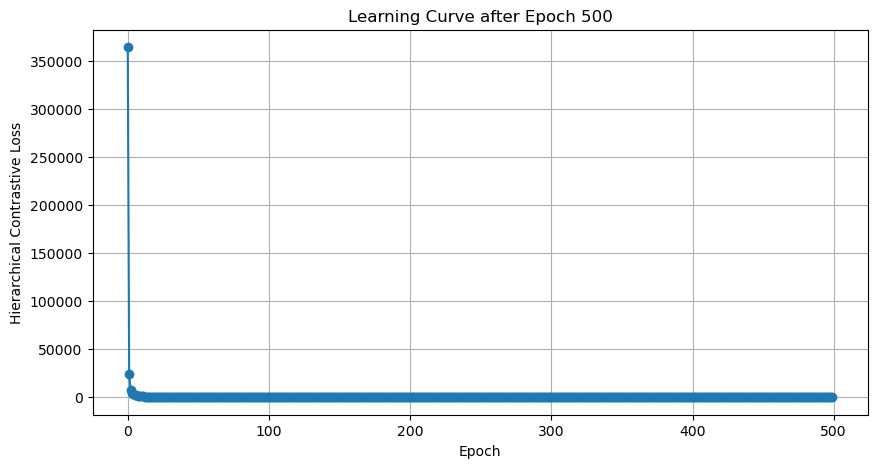


Generating test data (normal and abnormal samples)...
Predicting anomaly scores on the test set...


Predicting Anomaly Scores:   0%|          | 0/7 [00:00<?, ?it/s]

Visualizing results...


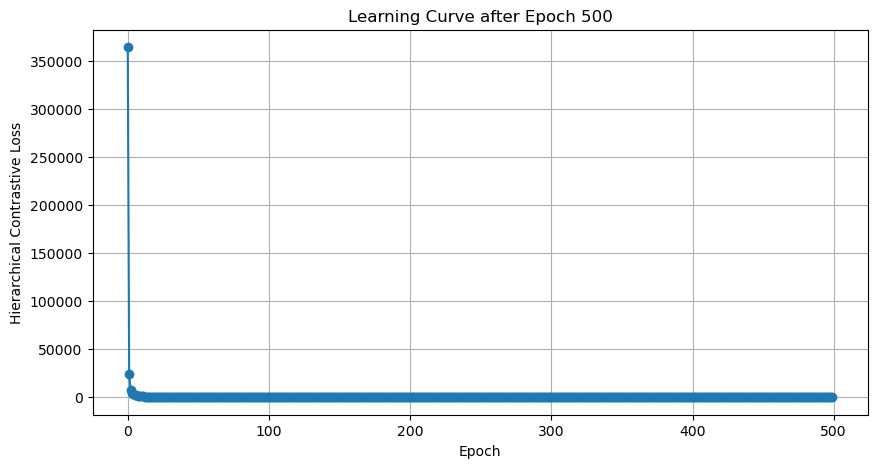

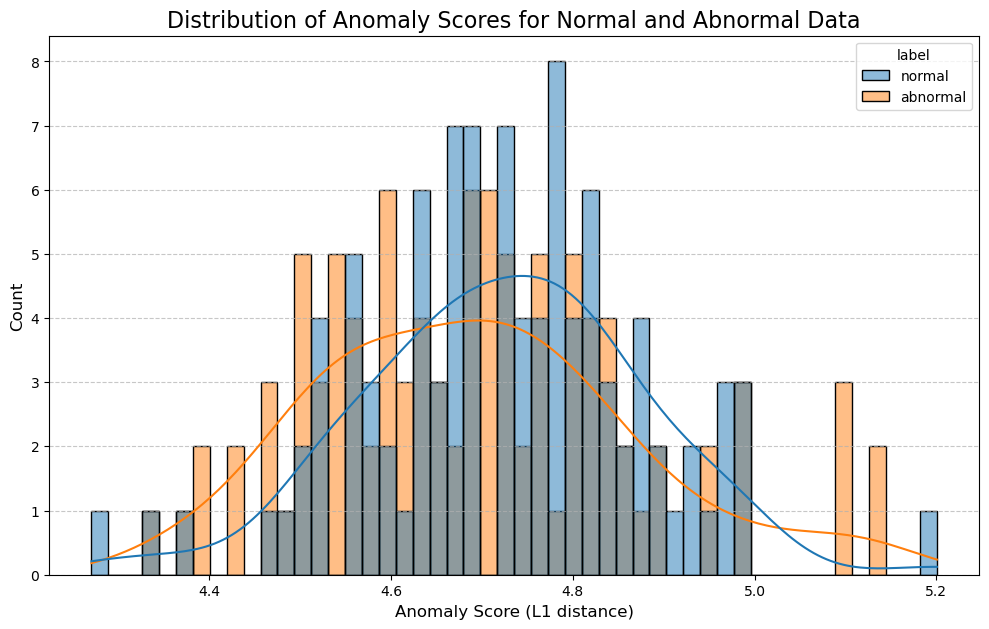

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings("ignore")
# (1) 寫一個torch.nn.Module來建構該論文模型
# (3) 各個細節、模型架構、訓練過程、損失函數設計，必須完全遵照論文設計

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding='same', dilation=dilation)
        self.gelu1 = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding='same', dilation=dilation)
        self.gelu2 = nn.GELU()
        self.dropout2 = nn.Dropout(dropout)

        # Skip connection - if channels differ, use a 1x1 conv
        self.skip_connection = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.gelu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.gelu2(out)
        out = self.dropout2(out)

        if self.skip_connection:
            residual = self.skip_connection(residual)
        
        return out + residual


class TS2Vec(nn.Module):
    def __init__(self, input_dims, output_dims=320, hidden_dims=64, depth=10):
        super().__init__()
        # Input projection layer
        self.input_projection = nn.Linear(input_dims, hidden_dims)

        # Dilated CNN encoder
        # According to Appendix C.2, it contains 10 hidden blocks
        layers = []
        for l in range(depth):
            dilation = 2**l
            layers.append(ResidualBlock(hidden_dims, hidden_dims, kernel_size=3, dilation=dilation))
        
        self.encoder = nn.Sequential(*layers)
        
        # Output projection to get final representations
        # Maps hidden channels to the final representation dimension
        self.output_projection = nn.Conv1d(hidden_dims, output_dims, kernel_size=1)

    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len, features)
        x = x.permute(0, 2, 1) # to (batch_size, features, seq_len) for Linear layer
        
        # Project input to high-dimensional latent vectors
        # Using a Conv1d with kernel size 1 is equivalent to a Linear layer applied to each timestamp
        z = self.input_projection(x.transpose(1, 2)).transpose(1, 2)
        
        # Timestamp Masking is applied here in the training loop
        if mask is not None:
             z = z * mask.unsqueeze(1)
                
        # Pass through dilated CNNs
        z_encoded = self.encoder(z)
        
        # Final representations
        r = self.output_projection(z_encoded) # shape: (batch_size, output_dims, seq_len)
        
        return r.transpose(1, 2) # to (batch_size, seq_len, output_dims)


# (4) 額外寫一個class agent
# (5) agent上寫.train和.predict
# (6) agent內建好模型的設定（包含各層設定、latent dim設定）
class Agent:
    def __init__(self, input_dims, device=None):
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Model configuration based on the paper
        self.model = TS2Vec(
            input_dims=input_dims,
            output_dims=320,  # As specified in paper (Table 1 caption, Appendix C.2)
            hidden_dims=64,   # As specified in Appendix C.2
            depth=10          # 10 residual blocks as specified in Appendix C.2
        ).to(self.device)
        
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-3)

    def _get_hierarchical_loss(self, r1, r2):
        """
        Calculates the hierarchical contrastive loss based on Section 2.4.
        Combines temporal and instance-wise contrastive losses over multiple scales.
        """
        total_loss = 0
        num_scales = 0
        
        # Clone representations to avoid modifying them in place
        r1_current, r2_current = r1.clone(), r2.clone()

        while r1_current.size(1) > 1:
            # Temporal Contrastive Loss (Eq. 1)
            # Similarity between the same timestamp in two views
            sim_pos_temporal = torch.einsum('bld,bld->bl', r1_current, r2_current)
            
            # Similarity between one timestamp and all others in the other view
            sim_neg_temporal1 = torch.einsum('bld,bmd->blm', r1_current, r2_current) # (batch, len, len)
            sim_neg_temporal2 = torch.einsum('bld,bmd->blm', r1_current, r1_current)
            
            # Combine negatives and apply logsumexp for stability
            temporal_pos = sim_pos_temporal
            temporal_all = torch.cat([sim_neg_temporal1, sim_neg_temporal2], dim=-1)
            
            temporal_loss = -torch.mean(temporal_pos - torch.logsumexp(temporal_all, dim=-1))

            # Instance-wise Contrastive Loss (Eq. 2)
            # Similarity between corresponding timestamps across batches
            sim_pos_instance = torch.einsum('bld,bld->bl', r1_current, r2_current)

            # Similarity between one sample's timestamp and all others' in the batch
            sim_neg_instance1 = torch.einsum('bld,cmd->bcl', r1_current, r2_current) # (batch, batch, len)
            sim_neg_instance2 = torch.einsum('bld,cmd->bcl', r1_current, r1_current)

            # Combine negatives
            instance_pos = sim_pos_instance
            instance_all = torch.cat([sim_neg_instance1, sim_neg_instance2], dim=1)
            
            instance_loss = -torch.mean(instance_pos - torch.logsumexp(instance_all, dim=1))
            
            # Dual Loss (Eq. 3) for the current scale
            dual_loss = temporal_loss + instance_loss
            total_loss += dual_loss
            num_scales += 1

            # Downsample for the next hierarchy level (MaxPool1d)
            # We need to permute for pooling: (B, L, D) -> (B, D, L)
            r1_current = F.max_pool1d(r1_current.transpose(1, 2), kernel_size=2).transpose(1, 2)
            r2_current = F.max_pool1d(r2_current.transpose(1, 2), kernel_size=2).transpose(1, 2)
            
        return total_loss / num_scales

    # (7) .train的input為dataloader和epochs...
    # (8) 每次畫圖前會先呼叫clear_output()
    def train(self, dataloader, epochs=50):
        self.model.train()
        total_losses = []
        fig, ax = plt.subplots(figsize=(10, 5))

        for epoch in tqdm(range(epochs), desc="Training Epochs"):
            epoch_losses = []
            for batch_x, in dataloader:
                batch_x = batch_x.to(self.device)
                B, T, F = batch_x.shape

                # 1. Random Cropping to create two overlapping views
                # We ensure the two crops overlap
                min_len = T // 2
                crop_len = np.random.randint(min_len, T)
                
                start1 = np.random.randint(0, T - crop_len + 1)
                start2 = np.random.randint(max(0, start1 - crop_len + 1), min(T - crop_len + 1, start1 + crop_len -1))

                crop1 = batch_x[:, start1:start1+crop_len, :]
                crop2 = batch_x[:, start2:start2+crop_len, :]
                
                # 2. Timestamp Masking
                # The paper applies masking on latent vectors (after input projection)
                # Here we create the mask to be applied in the forward pass.
                mask1 = torch.from_numpy(np.random.choice([0, 1], size=(B, crop_len), p=[0.5, 0.5])).to(self.device).float()
                mask2 = torch.from_numpy(np.random.choice([0, 1], size=(B, crop_len), p=[0.5, 0.5])).to(self.device).float()
                
                # Forward pass for both views
                r1_full = self.model(crop1, mask=mask1)
                r2_full = self.model(crop2, mask=mask2)
                
                # Identify the overlapping segment to enforce consistency
                overlap_start = max(start1, start2)
                overlap_end = min(start1 + crop_len, start2 + crop_len)
                
                # Slice the representations to get only the overlapping part
                r1_overlap = r1_full[:, overlap_start - start1 : overlap_end - start1, :]
                r2_overlap = r2_full[:, overlap_start - start2 : overlap_end - start2, :]
                
                if r1_overlap.size(1) == 0: # Skip if no overlap (should not happen with our logic)
                    continue

                self.optimizer.zero_grad()
                loss = self._get_hierarchical_loss(r1_overlap, r2_overlap)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.item())

            avg_epoch_loss = np.mean(epoch_losses)
            total_losses.append(avg_epoch_loss)

            if (epoch + 1) % 10 == 0:
                clear_output(wait=True)
                ax.clear()
                ax.plot(range(epoch + 1), total_losses, marker='o')
                ax.set_title(f'Learning Curve after Epoch {epoch + 1}')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Hierarchical Contrastive Loss')
                ax.grid(True)
                display(fig)

        clear_output(wait=True)
        print("Training Finished.")
        display(fig)

    # (9) .predict則是輸入dataloader，然後會給出異常分數（by sample）
    def predict(self, dataloader):
        self.model.eval()
        anomaly_scores = []

        with torch.no_grad():
            for batch_x, in tqdm(dataloader, desc="Predicting Anomaly Scores"):
                batch_x = batch_x.to(self.device)
                B, T, F = batch_x.shape
                
                # 1. Unmasked pass: get representation r_t^u
                # We only need the representation of the last timestamp
                r_unmasked = self.model(batch_x)
                r_t_u = r_unmasked[:, -1, :]
                
                # 2. Masked pass: get representation r_t^m
                # The paper masks the last observation's latent vector
                x_permuted = batch_x.permute(0, 2, 1)
                z = self.model.input_projection(x_permuted.transpose(1, 2)).transpose(1, 2)
                
                # Mask out the last observation *only*
                z[:, :, -1] = 0
                
                # Pass masked latent vector through the rest of the model
                r_masked_full = self.model.encoder(z)
                r_masked_full = self.model.output_projection(r_masked_full).transpose(1,2)
                
                r_t_m = r_masked_full[:, -1, :]

                # 3. Calculate anomaly score (L1 distance)
                score = torch.linalg.norm(r_t_u - r_t_m, ord=1, dim=1)
                anomaly_scores.extend(score.cpu().numpy())
                
        return np.array(anomaly_scores)


# (10) 最後寫主程式...
# --------------------- DATA GENERATORS ---------------------
import numpy as np
def normal_data_generator():
    # 第一段 48分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_1 = (np.random.normal(0, .5, size = (48, )) + base).tolist()
    
    base = float(np.random.normal(70, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    
    # 第二段 52分鐘
    base = float(np.random.normal(-20, 2, size = (1, )))
    series1_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .5, size = (52 + 30, )) + base).tolist()
    
    # 第三段 30分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_3 = ([base]*30).copy()
    
    series1 = series1_1 + series1_2 + series1_3
    series2 = series2_1 + series2_2
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

def abnormal_data_generator():
    base = float(np.random.normal(60, 2, size = (1, )))
    series1 = (np.random.normal(0, .5, size = (48+52+30, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    base = float(np.random.normal(-20, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_3 = ([base]*30).copy()
    series2 = series2_1 + series2_2 + series2_3
    
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

# --------------------- MAIN EXECUTION ---------------------
if __name__ == '__main__':
    # --- 1. Setup and Data Generation ---
    N_TRAIN = 500
    N_TEST_NORMAL = 100
    N_TEST_ABNORMAL = 100
    BATCH_SIZE = 16
    EPOCHS = 500 # Use a smaller number for a quick demo

    print("Generating training data (normal samples only)...")
    train_data = [normal_data_generator() for _ in range(N_TRAIN)]
    train_tensor = torch.tensor(np.array(train_data), dtype=torch.float32)
    train_dataset = TensorDataset(train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # --- 2. Agent Initialization and Training ---
    print("\nInitializing Agent...")
    # The agent will automatically get the input dimensions from the data
    agent = Agent(input_dims=train_tensor.shape[2]) 
    
    print(f"Starting training on {agent.device} for {EPOCHS} epochs...")
    agent.train(train_loader, epochs=EPOCHS)

    # --- 3. Test Data Generation and Prediction ---
    print("\nGenerating test data (normal and abnormal samples)...")
    test_normal = [normal_data_generator() for _ in range(N_TEST_NORMAL)]
    test_abnormal = [abnormal_data_generator() for _ in range(N_TEST_ABNORMAL)]
    
    test_data = test_normal + test_abnormal
    test_labels = [0] * N_TEST_NORMAL + [1] * N_TEST_ABNORMAL

    test_tensor = torch.tensor(np.array(test_data), dtype=torch.float32)
    test_dataset = TensorDataset(test_tensor)
    # Use a larger batch size for faster prediction
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2)

    print("Predicting anomaly scores on the test set...")
    anomaly_scores = agent.predict(test_loader)

    # --- 4. Visualization of Results ---
    print("Visualizing results...")
    results_df = pd.DataFrame({
        'score': anomaly_scores,
        'label': ['normal' if l == 0 else 'abnormal' for l in test_labels]
    })

    plt.figure(figsize=(12, 7))
    sns.histplot(data=results_df, x='score', hue='label', kde=True, bins=50)
    plt.title('Distribution of Anomaly Scores for Normal and Abnormal Data', fontsize=16)
    plt.xlabel('Anomaly Score (L1 distance)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# 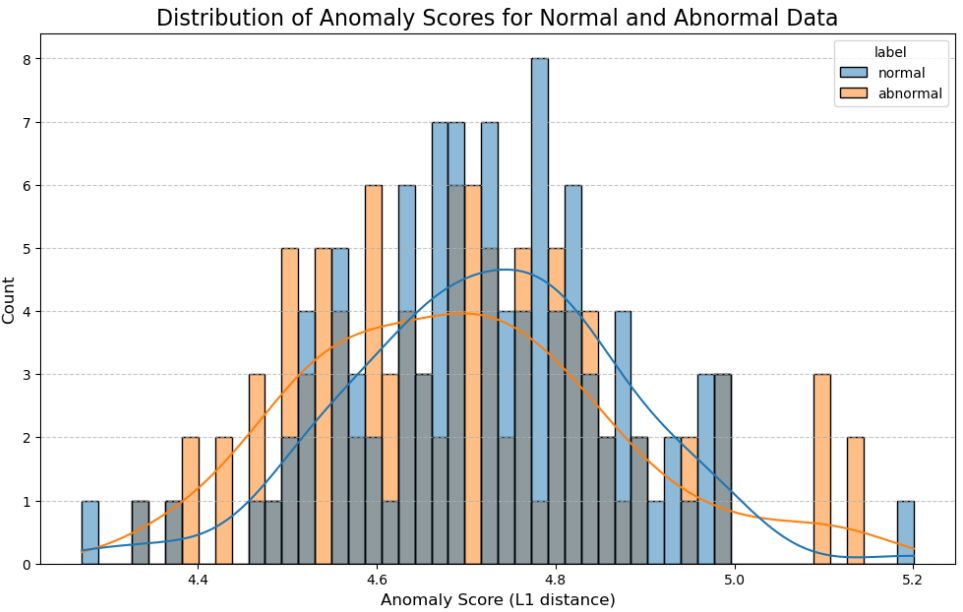